In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Read Data

In [3]:
data = pd.read_excel('/content/drive/MyDrive/tut/Folds5x2_pp.xlsx')

In [4]:
data.shape

(9568, 5)

In [68]:
data.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


## Data Visualization

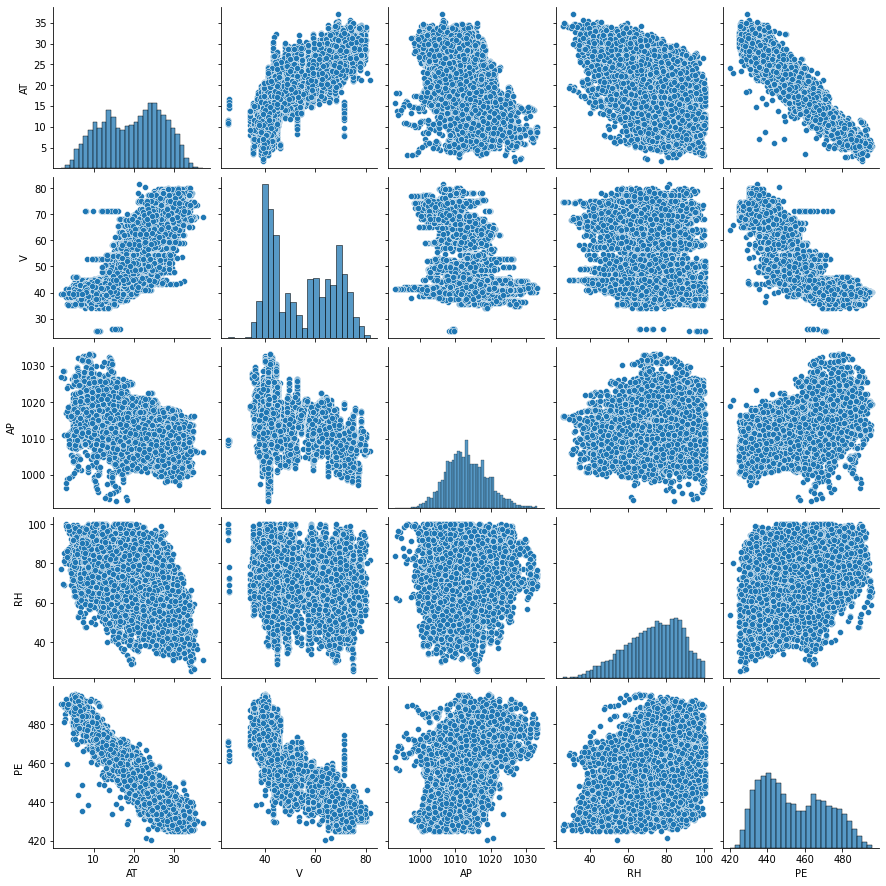

In [ ]:
sns.pairplot(data)

In [ ]:
data.corr()

,AT,V,AP,RH,PE
AT,1.000000,0.844107,-0.507549,-0.542535,-0.948128
V,0.844107,1.000000,-0.413502,-0.312187,-0.869780
AP,-0.507549,-0.413502,1.000000,0.099574,0.518429
RH,-0.542535,-0.312187,0.099574,1.000000,0.389794
PE,-0.948128,-0.869780,0.518429,0.389794,1.000000


##From the above visualization and the correlation matrix, we can clearly see that the target PE variable is more correlated with AT and V features, so they are the most contributed and predictive features. It can be seen clearly that AT and V are also high correlated with each other, so we must fix this.

The clean data function return two different versions of the data which are data without the V feature and the data with feature V an

In [ ]:
def clean_data(data):
  data_without_v = data.drop(columns='V' , axis= 1)
  y = data.copy()
  y['AT_V'] = y['AT'] + y['V']
  y.drop(columns=['AT' , 'V'] , axis = 1 , inplace = True)
  data_with_V_and_AT_combined = y[['AT_V' , 'AP' , 'RH' , 'PE']]
  return data_without_v , data_with_V_and_AT_combined

In [ ]:
data_1 , data_2 = clean_data(data)

#Pair Plot after merging AT and V features

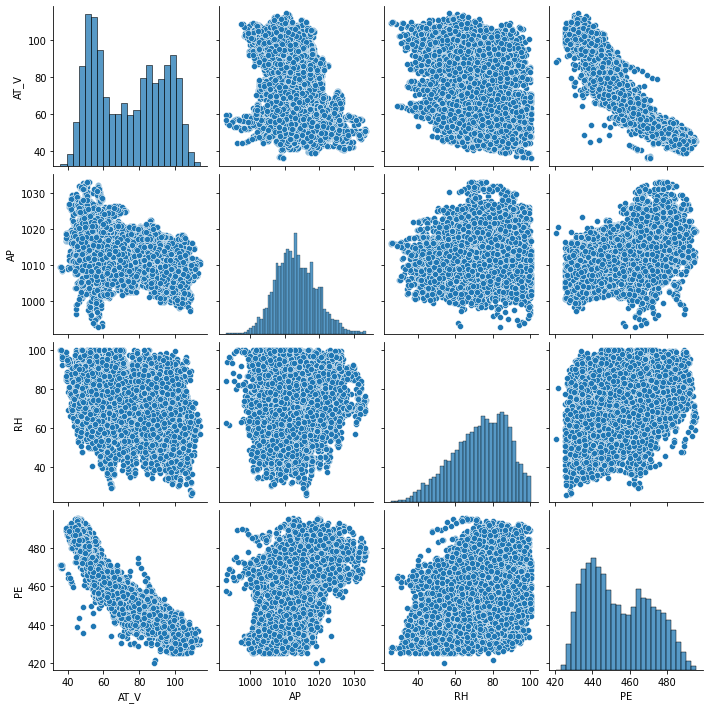

In [ ]:
sns.pairplot(data_2)

## Dealing with outliers

In [ ]:
def remove_outliers(data):
  """
  remove outliers from AV_T column
  """
  x1 = data.drop(data[(data['AT_V'] < 60) & (data['PE'] < 460)].index)
  x2 =  x1.drop(x1[(x1['AT_V'] < 50) & (x1['PE'] < 475)].index)     
  return x2

In [ ]:
data_withoutOutliers = remove_outliers(data_2)

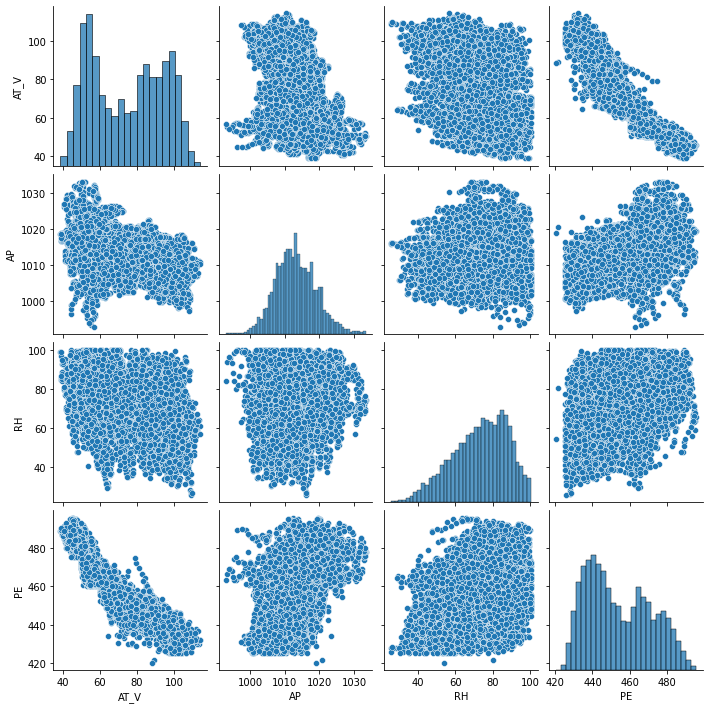

In [ ]:
sns.pairplot(data_withoutOutliers)

## Data Normalization

In [5]:
def normalize_data(data):
    data.iloc[:, :-1] =  data.iloc[:, :-1]/ data.iloc[:, :-1].max()

## Function to split the data to train and test

In [6]:
def split_data(df, split_percent):
    df = df.copy()
    normalize_data(df)
    X = df[df.columns[:-1]]
    y = df[df.columns[-1]]
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    train_index = int((1 - split_percent) * len(indices))
    x_train, x_test = X[:train_index], X[train_index:]
    y_train, y_test = y[:train_index], y[train_index:]
    return x_train.to_numpy(),y_train.to_numpy(), x_test.to_numpy(), y_test.to_numpy()

In [7]:
np.random.seed(10)
x_train,y_train, x_test, y_test = split_data(data, split_percent = 0.2)

In [32]:
x_train

array([[0.40312584, 0.51201569, 0.99106745, 0.73053115],
       [0.67852331, 0.77194703, 0.98716733, 0.58985623],
       [0.13769873, 0.48307994, 0.97954128, 0.91992812],
       ...,
       [0.69415252, 0.70279549, 0.97931869, 0.43540335],
       [0.30369173, 0.49889652, 0.9816607 , 0.86491613],
       [0.71921315, 0.86267778, 0.97437337, 0.68180911]])

In [182]:
y_test

array([483.12, 444.38, 442.85, ..., 429.57, 435.74, 453.28])

## Step 2

## Model Implementation

##Batch Gradient Descent

In [8]:
import numpy as np
class BGD:
  """
  implementation of batch gradient descent
  """
  def __init__(self , learning_rate = 1e-5 , max_iter = 500 , initial_theta_strategy = 'normal' , store_cost_while_fitting = False):
    self.learning_rate = learning_rate
    self.max_iter = max_iter
    self.initial_theta_strategy = initial_theta_strategy
    self.store_cost_while_fitting = store_cost_while_fitting

  def fit(self , X,y):
    """
    Computes the value of theta, 
    which is stored in self.theta,
    Parameters
    ------------------------------------------
    X: numpy array, an array of the features 
        also it should be scaled
    y: numpy array, an array of the target

    Returns
    ------------------------------------------
    None
    """
    N = len(X) # number of training examples
    d = len(X[0]) # number of features
    X_arr = X 
    y_arr = y.reshape((N,1)) 
    cost_arr = []
    self._initialize_theta(d)
    counter = 0
    while counter < self.max_iter:
      self.theta -= self.learning_rate * X_arr.T @ (X_arr @ self.theta - y_arr)
      if self.store_cost_while_fitting:
        cost_arr.append(self.cost(X,y))
      counter += 1 
    if self.store_cost_while_fitting:
      return cost_arr  

  def predict(self,X):
    result = X @ self.theta
    return result

  def cost(self, X ,y):
    N = len(X) # number of training data
    y = y.reshape(N,1)
    predictions = self.predict(X)
    result = np.dot((predictions - y).T , (predictions - y))/N
    return result[0][0]

  def _initialize_theta(self , d):
    if self.initial_theta_strategy == 'normal':
      self.theta = np.random.randn(d,1)
    elif self.initial_theta_strategy == 'zeros':
      self.theta = np.zeros(d,1) 
    elif self.initial_theta_strategy == 'ones':
      self.theta = np.ones(d,1)    

In [ ]:
model = BGD(store_cost_while_fitting=True, learning_rate=1e-5, max_iter=10000)

In [ ]:
cost = model.fit(x_train, y_train)

In [ ]:
cost[-1]

25.376027132748558

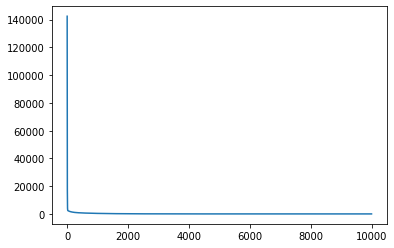

In [ ]:
plt.plot(np.arange(len(cost)), cost)

In [ ]:
optimal_theta = np.linalg.inv(x_train.T @ x_train) @ x_train.T @ y_train

In [ ]:
optimal_theta

array([-62.80092347, -21.68088108, 519.64998731, -10.27374543])

In [ ]:
prediction_opt = x_test @ optimal_theta

In [ ]:
prediction_opt

array([485.00556528, 443.76796414, 444.24727797, ..., 432.89743557,
       443.58499839, 451.43366282])

In [ ]:
np.sum((prediction_opt - y_test)**2)/len(y_test)

26.328542073081685

In [ ]:
predictions_from_our_model = model.predict(x_test)

In [ ]:
predictions_from_our_model

array([[484.47804371],
       [443.30506105],
       [444.59121322],
       ...,
       [432.40263603],
       [443.20477758],
       [451.17442672]])

In [ ]:

np.sum((predictions_from_our_model.reshape(-1) - y_test)**2)/ len(y_test)

26.272957829598113

so the predictions from our model are very close to the optimal predictions given by the analytical solution (closed form solution) .

##Stochastic Gradient Descent

In [9]:
import numpy as np
import random
class SGD:
    "Implementation of stochastic batch gradient descent"
    def __init__(self, learning_rate = 1e-4 ,  max_iter = 100000, initial_theta_strategy = 'normal', store_cost_while_fitting = False):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.initial_theta_strategy = initial_theta_strategy
        self.store_cost_while_fitting = store_cost_while_fitting
    
    def fit(self, X,y):
        """
        Computes the value of theta, 
        which is stored in self.theta,
        Parameters
        ------------------------------------------
        X: numoy array, an array of the features 
           also it should be scaled
        y: numpy array, an array of the target

        Returns
        ------------------------------------------
        None
        """
        N = len(X) # number of trainning examples
        d = len(X[0]) # number of features
        X_arr = X.copy() # convert the data frame to numpy array
        y_arr = y.reshape((N,1)).copy() # convert the data frame to numpy array
        cost_arr = []
        self._initialize_theta(d)
        counter = 0
        while counter < self.max_iter:
            #np.random.shuffle(X_arr)
            indices = np.arange(len(X_arr))
            np.random.shuffle(indices)
            X_arr = X_arr[indices]
            y_arr = y_arr[indices]
            for i in range(0,N):
                #print(y_arr[i])
                self.theta -= self.learning_rate * X_arr[i, :].reshape(d,1) * (np.dot(X_arr[i,:],self.theta) - y_arr[i])
            if self.store_cost_while_fitting:
                cost_arr.append(self.cost(X, y))
            counter += 1
        if self.store_cost_while_fitting:
            return cost_arr

    def predict(self, X):
        result = X @ self.theta
        return result
    def cost(self, X, y):
        N = len(X) # the number of training examples
        y = y.reshape(N,1)
        predictions = self.predict(X)
        result = np.dot((predictions - y).T, predictions - y)/N
        return result[0][0]

    def _initialize_theta(self,d):
        
        if self.initial_theta_strategy == "normal":
            self.theta = np.random.randn(d,1)
        elif self.initial_theta_strategy == 'zeros':
            self.theta = np.zeros((d,1))
        elif self.initial_theta_strategy == 'ones':
            self.theta = np.ones((d,1))

In [ ]:
sgd_model = SGD(store_cost_while_fitting=True, max_iter = 10, learning_rate=1e-2)

In [ ]:
cost = sgd_model.fit(x_train, y_train)

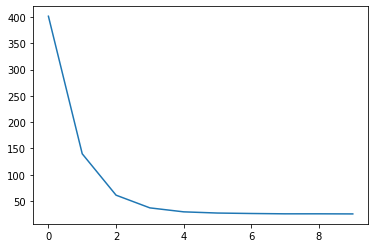

In [ ]:
plt.plot(np.arange(len(cost)), cost)

In [ ]:
cost[-1]

25.41436299685943

In [ ]:
predictions = sgd_model.predict(x_test)

In [ ]:
predictions = predictions.reshape(len(predictions))

In [ ]:
predictions

array([484.77722569, 443.41186267, 444.64489723, ..., 432.34892361,
       443.28920475, 451.31027976])

In [ ]:
y_test

array([483.12, 444.38, 442.85, ..., 429.57, 435.74, 453.28])

In [ ]:
np.sum((predictions.reshape(-1) - y_test)**2) / len(y_test)

26.328660164405736

## Mini-Batch Gradient Descent


In [10]:
import numpy as np

class MBGD:
    "Implementation of batch gradient descent"
    def __init__(self, learning_rate = 1e-5 , batch_size = 16, max_iter = 500, initial_theta_strategy = 'normal', store_cost_while_fitting = False):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.initial_theta_strategy = initial_theta_strategy
        self.store_cost_while_fitting = store_cost_while_fitting
    
    def fit(self, X,y):
        """
        Computes the value of theta, 
        which is stored in self.theta,
        Parameters
        ------------------------------------------
        X: numoy array, an array of the features 
           also it should be scaled
        y: numpy array, an array of the target

        Returns
        ------------------------------------------
        None
        """
        X_arr = X # convert the data frame to numpy arrayk
        N = len(X_arr) # number of trainning examples
        y_arr = y.reshape((N,1)) # convert the data frame to numpy array
        d = len(X_arr[0]) # number of features
        assert self.batch_size < N # ensure that batch size is less than N        
        no_epochs = N // self.batch_size
        cost_arr = []
        self._initialize_theta(d)
        counter = 0
        while counter < self.max_iter:
            for i in range(no_epochs-1):
                X_current = X_arr[ i * self.batch_size : (i+1) * self.batch_size ,:]
                y_current = y_arr[ i * self.batch_size : (i+1) * self.batch_size ,:]
                self.theta -= self.learning_rate * X_current.T @ (X_current @ self.theta - y_current)
            if self.store_cost_while_fitting:
                # print(self.cost(X_arr, y_arr)[0][0])
                cost_arr.append(self.cost(X_arr, y_arr))
            counter += 1
        if self.store_cost_while_fitting:
            return cost_arr

    def predict(self, X):
        """
        Parameters
        ------------------------------------------
        X: numpy array, an array of the input features

        Returns
        ------------------------------------------
        result: numpy array, array of the predicted values
        """
        result = X @ self.theta
        return result
    def cost(self, X, y):
        """
        Parameters:
        ------------------------------------------
        X: numpy array, the input array
        y: numpy array, array of the target values

        Returns
        ------------------------------------------
        result: float, the mean squared error
        """
        N = len(X) # the number of training examples
        predictions = self.predict(X)
        result = np.dot((predictions.reshape(-1) - y.reshape(-1)).T, predictions.reshape(-1) - y.reshape(-1))/N
        return result

    def _initialize_theta(self,d):
        """
        Parameters:
        -----------------------------------------
        d: int, the number of features
        """
        if self.initial_theta_strategy == "normal":
            self.theta = np.random.randn(d,1)
        elif self.initial_theta_strategy == 'zeros':
            self.theta = np.zeros((d,1))
        elif self.initial_theta_strategy == 'ones':
            self.theta = np.ones((d,1))



    def train_test_error_calculate(self, X,y,X_test,y_test):
      """
      Computes the value of theta, 
      which is stored in self.theta,
      Parameters
      ------------------------------------------
      X: numoy array, an array of the features 
      also it should be scaled
      y: numpy array, an array of the target

      Returns
      ------------------------------------------
      None
      """
      X_arr = X # convert the data frame to numpy arrayk
      N = len(X_arr) # number of trainning examples
      y_arr = y.reshape((N,1)) # convert the data frame to numpy array
      d = len(X_arr[0]) # number of features
      assert self.batch_size < N # ensure that batch size is less than N        
      no_epochs = N // self.batch_size
      cost_arr = []
      cost_test_arr = []
      self._initialize_theta(d)
      counter = 0
      while counter < self.max_iter:
        for i in range(no_epochs-1):
           X_current = X_arr[ i * self.batch_size : (i+1) * self.batch_size ,:]
           y_current = y_arr[ i * self.batch_size : (i+1) * self.batch_size ,:]
           self.theta -= self.learning_rate * X_current.T @ (X_current @ self.theta - y_current)
        if self.store_cost_while_fitting:
           test_pred = self.predict(X_test)
           p_n = test_pred.reshape(len(test_pred))
           cost_test = np.sum((p_n - y_test)**2) / len(y_test)
           print(cost_test)
           cost_test_arr.append(cost_test)
           cost_arr.append(self.cost(X_arr, y_arr)[0][0])
        counter += 1
      if self.store_cost_while_fitting:
          return cost_arr , cost_test_arr

    

In [ ]:
model = MBGD(store_cost_while_fitting=True, learning_rate=1e-5, max_iter=5000, batch_size =16)

In [ ]:
cost = model.fit(x_train, y_train)

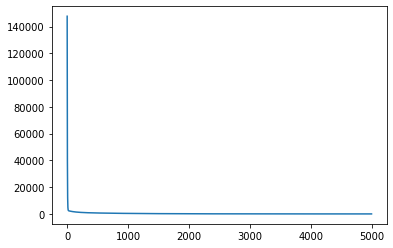

In [ ]:
plt.plot(np.arange(len(cost)), cost)

In [ ]:
x_test

array([[0.1738076 , 0.43857283, 0.98602536, 0.67731629],
       [0.64295338, 0.91871015, 0.98410916, 0.71325879],
       [0.7318782 , 0.58153507, 0.97664763, 0.45716853],
       ...,
       [0.84397736, 0.9113536 , 0.98027678, 0.36421725],
       [0.65966047, 0.85152035, 0.98118649, 0.62290335],
       [0.58205335, 0.76655223, 0.98444789, 0.67761581]])

In [ ]:
predictions = model.predict(x_test)

In [ ]:
y_n = y_test
p_n = predictions.reshape(-1)

In [ ]:
y_n

array([483.12, 444.38, 442.85, ..., 429.57, 435.74, 453.28])

In [ ]:
p_n

array([480.73031584, 443.2107408 , 442.83618882, ..., 429.30924058,
       442.21976397, 450.44038821])

In [ ]:
np.sum((p_n - y_n)**2) / len(y_test)

29.60117865432853

## Step 3

## Regularization

## Batch Gradient Descent with Regularization

In [11]:
import numpy as np
class BGD_Reg:
    "Implementation of batch gradient descent"
    def __init__(self, learning_rate = 1e-5 ,  max_iter = 500, initial_theta_strategy = 'normal', store_cost_while_fitting = False, l1 = 0, l2 = 1):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.initial_theta_strategy = initial_theta_strategy
        self.store_cost_while_fitting = store_cost_while_fitting
        self.l1 = l1
        self.l2 = l2
    
    def fit(self, X,y):
        """
        Computes the value of theta, 
        which is stored in self.theta,
        Parameters
        ------------------------------------------
        X: numoy array, an array of the features 
           also it should be scaled
        y: numpy array, an array of the target

        Returns
        ------------------------------------------
        None
        """
        N = len(X) # number of trainning examples
        d = len(X[0]) # number of features
        X_arr = X # convert the data frame to numpy array
        y_arr = y.reshape((N,1)) # convert the data frame to numpy array
        cost_arr = []
        self._initialize_theta(d)
        counter = 0
        while counter < self.max_iter:
            self.theta -= self.learning_rate * (X_arr.T @ (X_arr @ self.theta - y_arr) + self._reg_grad())

            if self.store_cost_while_fitting:
                cost_arr.append(self.cost(X, y))
            counter += 1
        if self.store_cost_while_fitting:
            return cost_arr
        pass
        
    def predict(self, X):
        """
        Parameters
        ------------------------------------------
        X: numpy array, an array of the input features

        Returns
        ------------------------------------------
        result: numpy array, array of the predicted values
        """
        result = X @ self.theta
        return result

    def cost(self, X, y):
        """
        Parameters:
        ------------------------------------------
        X: numpy array, the input array
        y: numpy array, array of the target values

        Returns
        ------------------------------------------
        result: float, the mean squared error
        """
        N = len(X) # the number of training examples
        y = y.reshape(N,1)
        predictions = self.predict(X)
        result = np.dot((predictions - y).T, predictions - y)/N
        return result[0][0]

    def _initialize_theta(self,d):
        """
        initialize theta with values based on
        the attribute initial_theta_strategy
        Parameters:
        -----------------------------------------
        d: int, the number of features
        """
        if self.initial_theta_strategy == "normal":
            self.theta = np.random.randn(d,1)
        elif self.initial_theta_strategy == 'zeros':
            self.theta = np.zeros((d,1))
        elif self.initial_theta_strategy == 'ones':
            self.theta = np.ones((d,1))
    def _reg_grad(self):
        d = len(self.theta)
        return self.l2 * self.theta.reshape(d,1) + self.l1 * (2 * (self.theta > 0).astype(int) - 1).reshape(d,1) 

L2-Regularization

In [ ]:
model = BGD_Reg(max_iter=10000, learning_rate=1e-4, store_cost_while_fitting=True, l2 = 1)

In [ ]:
cost = model.fit(x_train, y_train)

In [ ]:
cost[-1]

25.63438528324027

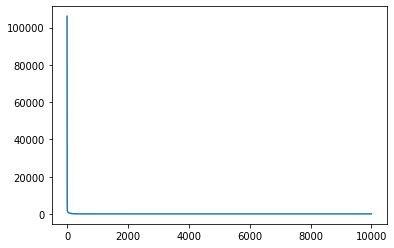

In [ ]:
plt.plot(np.arange(len(cost)), cost)

In [ ]:
predictions = model.predict(x_test)
predictions

array([[483.74182852],
       [444.03031468],
       [443.43081516],
       ...,
       [432.14185103],
       [443.47074223],
       [451.30549576]])

In [ ]:
y_n = y_test
p_n = predictions.reshape(len(predictions))

In [ ]:
np.sum((p_n - y_n)**2) / len(y_test)

26.556713002838336

L1-Regularization

In [ ]:
model = BGD_Reg(max_iter=1000, learning_rate=1e-4, store_cost_while_fitting=True, l1 = 2)

In [ ]:
cost = model.fit(x_train, y_train)

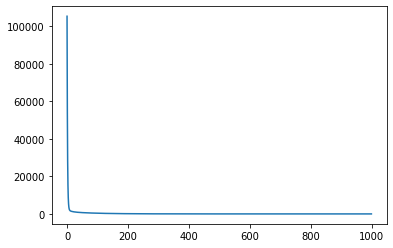

In [ ]:
plt.plot(np.arange(len(cost)), cost)

In [ ]:
predictions = model.predict(x_test)
predictions

array([[483.26561979],
       [443.62292537],
       [443.72967269],
       ...,
       [431.69888659],
       [443.13377175],
       [451.0754433 ]])

In [ ]:
y_n = y_test
p_n = predictions.reshape(len(predictions))

In [ ]:
np.sum((p_n - y_n)**2) / len(y_test)

26.65689278798087

Elastic Net Regularization

In [ ]:
model = BGD_Reg(max_iter=1000, learning_rate=1e-4, store_cost_while_fitting=True, l1 = 2, l2 = 2)

In [ ]:
cost = model.fit(x_train, y_train)

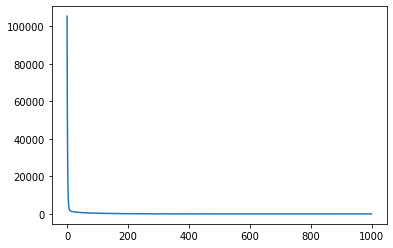

In [ ]:
plt.plot(np.arange(len(cost)), cost)

In [ ]:
predictions = model.predict(x_test)
predictions

array([[482.10910449],
       [443.94194569],
       [442.891754  ],
       ...,
       [431.03792629],
       [443.07644365],
       [450.98690259]])

In [ ]:
np.sum((p_n - y_n)**2) / len(y_test)

26.65689278798087

## Mini-Batch Gradient Descent with regularization

In [12]:
import numpy as np

class MBGD_Reg:
    "Implementation of batch gradient descent"
    def __init__(self, learning_rate = 1e-5 , batch_size = 16, max_iter = 500, initial_theta_strategy = 'normal', store_cost_while_fitting = False, l1 = 0, l2 = 0):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.initial_theta_strategy = initial_theta_strategy
        self.store_cost_while_fitting = store_cost_while_fitting
        self.l1 = l1
        self.l2 = l2
    
    def fit(self, X,y):
        """
        Computes the value of theta, 
        which is stored in self.theta,
        Parameters
        ------------------------------------------
        X: numoy array, an array of the features 
           also it should be scaled
        y: numpy array, an array of the target

        Returns
        ------------------------------------------
        None
        """
        X_arr = X # convert the data frame to numpy arrayk
        N = len(X_arr) # number of trainning examples
        y_arr = y.reshape((N,1)) # convert the data frame to numpy array
        d = len(X_arr[0]) # number of features
        assert self.batch_size < N # ensure that batch size is less than N        
        no_epochs = N // self.batch_size
        cost_arr = []
        self._initialize_theta(d)
        counter = 0
        while counter < self.max_iter:
            for i in range(no_epochs-1):
                X_current = X_arr[ i * self.batch_size : (i+1) * self.batch_size ,:]
                y_current = y_arr[ i * self.batch_size : (i+1) * self.batch_size ,:]
                self.theta -= self.learning_rate * (X_current.T @ (X_current @ self.theta - y_current) + self._reg_grad())
            if self.store_cost_while_fitting:
                cost_arr.append(self.cost(X_arr, y_arr))
            counter += 1
        if self.store_cost_while_fitting:
            return cost_arr

    def predict(self, X):
        """
        Parameters
        ------------------------------------------
        X: numpy array, an array of the input features

        Returns
        ------------------------------------------
        result: numpy array, array of the predicted values
        """
        result = X @ self.theta
        return result
    def cost(self, X, y):
        """
        Parameters:
        ------------------------------------------
        X: numpy array, the input array
        y: numpy array, array of the target values

        Returns
        ------------------------------------------
        result: float, the mean squared error
        """
        N = len(X) # the number of training examples
        predictions = self.predict(X)
        result = np.dot((predictions.reshape(-1) - y.reshape(-1)).T, predictions.reshape(-1) - y.reshape(-1))/N
        return result

    def _initialize_theta(self,d):
        """
        initialize theta with values based on
        the attribute initial_theta_strategy
        Parameters:
        -----------------------------------------
        d: int, the number of features
        """
        if self.initial_theta_strategy == "normal":
            self.theta = np.random.randn(d,1)
        elif self.initial_theta_strategy == 'zeros':
            self.theta = np.zeros((d,1))
        elif self.initial_theta_strategy == 'ones':
            self.theta = np.ones((d,1))
    def _reg_grad(self):
        d = len(self.theta)
        return self.l2 * self.theta.reshape(d,1) + self.l1 * (2 * (self.theta > 0).astype(int) - 1).reshape(d,1) 

L2 Regularization

In [ ]:
model = MBGD_Reg(max_iter=1000, learning_rate=1e-4, store_cost_while_fitting=True, l2 = 0.1)

In [ ]:
cost = model.fit(x_train, y_train)

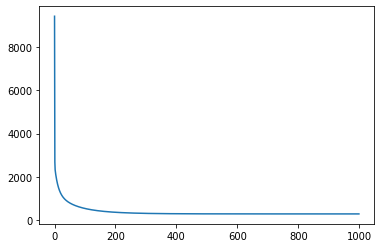

In [ ]:
plt.plot(np.arange(len(cost)), cost)

In [ ]:
predictions = model.predict(x_test)
predictions

array([[450.46713537],
       [453.98526949],
       [420.30068688],
       ...,
       [416.58342462],
       [443.02499448],
       [449.21253678]])

In [ ]:
y_n = y_test
p_n = predictions.reshape(len(predictions))

In [ ]:
np.sum((p_n - y_n)**2) / len(y_test)

267.1572588933264

L1 Regularization

In [ ]:
model = MBGD_Reg(max_iter=1000, learning_rate=1e-4, store_cost_while_fitting=True, l1 = 1)

In [ ]:
cost = model.fit(x_train, y_train)

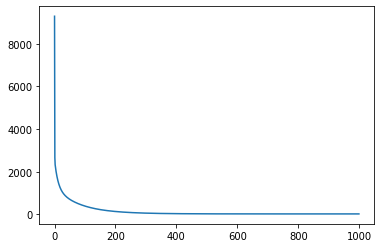

In [ ]:
plt.plot(np.arange(len(cost)), cost)

In [ ]:
predictions = model.predict(x_test)
predictions

array([[482.23657879],
       [444.22097984],
       [442.85007989],
       ...,
       [431.24010007],
       [443.29768184],
       [451.16951037]])

In [ ]:
y_n = y_test
p_n = predictions.reshape(len(predictions))

In [ ]:
np.sum((p_n - y_n)**2) / len(y_test)

27.659939271553704

Elastic Net Regularization

In [ ]:
model = MBGD_Reg(max_iter=1000, learning_rate=1e-4, store_cost_while_fitting=True, l1 = 1, l2 = 1)

In [ ]:
cost = model.fit(x_train, y_train)

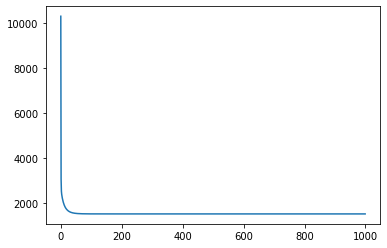

In [ ]:
plt.plot(np.arange(len(cost)), cost)

In [ ]:
predictions = model.predict(x_test)
predictions

array([[393.85073117],
       [465.0641483 ],
       [396.60382617],
       ...,
       [417.33900357],
       [444.70034486],
       [442.89483164]])

In [ ]:
np.sum((p_n - y_n)**2) / len(y_test)

27.659939271553704

## Stochastic gradient descent with Regularization

In [13]:
import numpy as np
import random
class SGD_Reg:
    "Implementation of stochastic batch gradient descent"
    def __init__(self, learning_rate = 1e-4 ,  max_iter = 100000, initial_theta_strategy = 'normal', store_cost_while_fitting = False, l1 = 0, l2= 0):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.initial_theta_strategy = initial_theta_strategy
        self.store_cost_while_fitting = store_cost_while_fitting
        self.l1 = l1
        self.l2 = l2
    
    def fit(self, X,y):
        N = len(X) # number of trainning examples
        d = len(X[0]) # number of features
        X_arr = X.copy() # convert the data frame to numpy array
        y_arr = y.reshape((N,1)).copy() # convert the data frame to numpy array
        cost_arr = []
        self._initialize_theta(d)
        counter = 0
        while counter < self.max_iter:
            #np.random.shuffle(X_arr)
            indices = np.arange(len(X_arr))
            np.random.shuffle(indices)
            X_arr = X_arr[indices]
            y_arr = y_arr[indices]
            for i in range(0,N):
                self.theta -= self.learning_rate * (X_arr[i, :].reshape(d,1) * (np.dot(X_arr[i,:],self.theta) - y_arr[i]) + self._reg_grad())
            if self.store_cost_while_fitting:
                cost_arr.append(self.cost(X, y))
            counter += 1
        if self.store_cost_while_fitting:
            return cost_arr

    def predict(self, X):
        """
        Parameters
        ------------------------------------------
        X: numpy array, an array of the input features

        Returns
        ------------------------------------------
        result: numpy array, array of the predicted values
        """
        result = X @ self.theta
        return result
    def cost(self, X, y):
        """
        Parameters:
        ------------------------------------------
        X: numpy array, the input array
        y: numpy array, array of the target values

        Returns
        ------------------------------------------
        result: float, the mean squared error
        """
        N = len(X) # the number of training examples
        y = y.reshape(N,1)
        predictions = self.predict(X)
        result = np.dot((predictions.reshape(-1) - y.reshape(-1)).T, predictions.reshape(-1) - y.reshape(-1))/N
        return result

    def _initialize_theta(self,d):
        """
        initialize theta with values based on
        the attribute initial_theta_strategy
        Parameters:
        -----------------------------------------
        d: int, the number of features
        """
        if self.initial_theta_strategy == "normal":
            self.theta = np.random.randn(d,1)
        elif self.initial_theta_strategy == 'zeros':
            self.theta = np.zeros((d,1))
        elif self.initial_theta_strategy == 'ones':
            self.theta = np.ones((d,1))
            
    def _reg_grad(self):
        d = len(self.theta)
        return self.l2 * self.theta.reshape(d,1) + self.l1 * (2 * (self.theta > 0).astype(int) - 1).reshape(d,1)




L2 Regularization

In [ ]:
model = SGD_Reg(max_iter=200, learning_rate=1e-2, store_cost_while_fitting=True, l1 = 1)

In [ ]:
cost = model.fit(x_train, y_train)

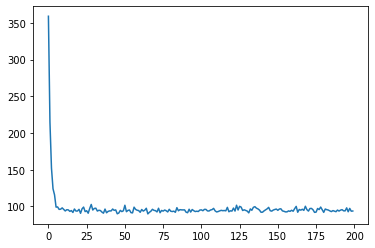

In [ ]:
plt.plot(np.arange(len(cost)), cost)

In [ ]:
predictions = model.predict(x_test)
predictions

array([[468.01599241],
       [451.73051422],
       [443.67868679],
       ...,
       [441.15837822],
       [449.24481449],
       [453.69725094]])

In [ ]:
np.sum((predictions.reshape(-1) - y_test.reshape(-1))**2) / len(y_test)

92.81028951791963

L1 Regularization

In [ ]:
model = SGD_Reg(max_iter=100, learning_rate=1e-4, store_cost_while_fitting=True, l1 = 1)

In [ ]:
cost = model.fit(x_train, y_train)

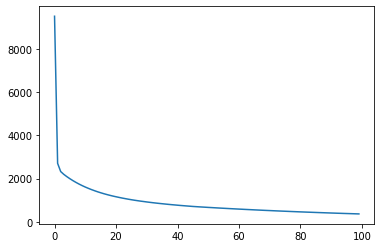

In [ ]:
plt.plot(np.arange(len(cost)), cost)

In [ ]:
predictions = model.predict(x_test)
predictions

array([[446.56521501],
       [452.21274484],
       [416.97797464],
       ...,
       [408.39089503],
       [439.88866817],
       [447.37943137]])

Elastic Net Regularization

In [ ]:
model = SGD_Reg(max_iter=500, learning_rate=1e-3, store_cost_while_fitting=True, l1 = 1, l2 = 2)

In [ ]:
cost = model.fit(x_train, y_train)

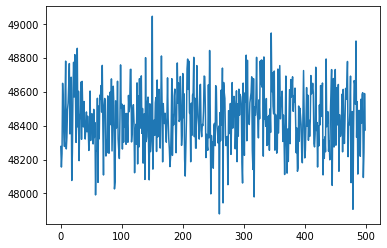

In [ ]:
plt.plot(np.arange(len(cost)), cost)

In [ ]:
predictions = model.predict(x_test)
predictions

array([[198.64444717],
       [259.66002909],
       [219.95640118],
       ...,
       [241.75600261],
       [248.41150699],
       [243.075964  ]])

In [ ]:
np.sum((p_n - y_n)**2) / len(y_test)

27.659939271553704

## the affect of regularization on weights

In [14]:
data.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [15]:
normalize_data(data)

In [16]:
x_train,y_train,x_test , y_test = split_data(data , 0.2)

In [27]:
#for lambda between [-10, 10]
# make new model with this lamda 
#save theta

result_1 = []
weight_1 = []

for l2 in np.linspace(0,10,10):

    model_1= SGD_Reg(max_iter=10,learning_rate=1e-2, store_cost_while_fitting=True, l1 = 0, l2=l2)
   
    
    model_1.fit(x_train,y_train)
 
    
    l2_norm_theta_1 = np.linalg.norm(model_1.theta , 2)
 
    
    result_1.append(l2_norm_theta_1)
    weight_1.append(model_1.theta)


lowest_norm_l2 = result_1[np.argmin(result_1)]
highest_norm_l2 =result_1[np.argmax(result_1)]
theta_with_highest_norm_l2 = weight_1[np.argmax(result_1)]
theta_with_lowest_norm_l2 = weight_1[np.argmin(result_1)]   
 

Lowest norm in case of l2 regularization :

In [28]:
lowest_norm_l2

55.01170754422736

Value of weight in case of l2 regularization :

In [29]:
theta_with_lowest_norm_l2

array([[20.87996408],
       [24.90363422],
       [36.22014632],
       [25.65589737]])

Highest norm in case of l2 regularization :

In [30]:
highest_norm_l2

522.7162271174265

Value of weight in case of l2

In [31]:
theta_with_highest_norm_l2

array([[-59.43582995],
       [-24.73979767],
       [518.67239688],
       [ -8.156184  ]])

Plot of lambdas against norms in case of SGD

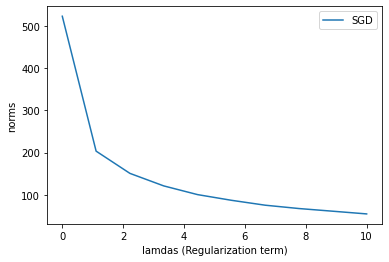

In [32]:
plt.plot(np.linspace(0,10,10),result_1, label = 'SGD')
plt.xlabel('lamdas (Regularization term)')
plt.ylabel('norms')
plt.legend()

from the above plots you will notice that as lambda increases the cost decrease.

In [23]:
#for lambda between [-10, 10]
# make new model with this lamda 
#save theta

result_1 = []
weight_1 = []

for l1 in np.linspace(0,10,10):
   
    model_1 = SGD_Reg(max_iter=10, learning_rate=1e-2, store_cost_while_fitting=True, l1 = l1, l2 =0)
    
    model_1.fit(x_train,y_train)
   
    
    l2_norm_theta_1 = np.linalg.norm(model_1.theta , 2)
  
    
    result_1.append(l2_norm_theta_1)
    weight_1.append(model_1.theta)
   

lowest_norm = result_1[np.argmin(result_1)]
highest_norm =result_1[np.argmax(result_1)]
theta_with_highest_norm = weight_1[np.argmax(result_1)]
theta_with_lowest_norm = weight_1[np.argmin(result_1)]   
 

Lowest norm in case of l1 regularization :

In [24]:
lowest_norm

450.3794961189766

Theta that produces the lowest norm

In [25]:
theta_with_lowest_norm

array([[-8.38897571e-03],
       [ 1.18800469e-01],
       [ 4.50132293e+02],
       [ 1.49196252e+01]])

Highest norm in case of l1 regularization :

In [26]:
highest_norm

523.0933606946978

so we can see that the range in case  of l2 regularization is larger than l1 reularization as expected because there is more sparsity in l1 regularization.

## Step 4

## Exploring the model weights and hyperparameters

J. Using Mini-batch GD, a 20% test size and a lr of 0.01, fit the training samples, and
predict on the training samples and test samples. Store the MSE error for each
epoch during training in an array. You can write a function to perform this.
Plot the train and test error as a function of the number of epochs. How does the
error behave as the epoch increases?

In [ ]:
np.random.seed(10)
x_train,y_train, x_test, y_test = split_data(data, split_percent = 0.2)

In [ ]:
model = MBGD(store_cost_while_fitting=True, learning_rate=1e-2, max_iter=50, batch_size =50)

In [ ]:
cost = model.fit(x_train, y_train)

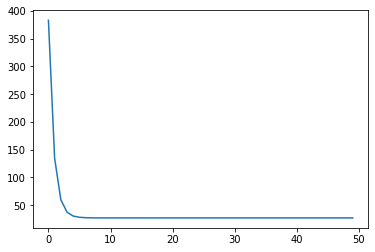

In [ ]:
plt.plot((cost))

In [ ]:
train_predictions = model.predict(x_train)
train_predictions

array([[472.32817518],
       [448.88974671],
       [481.7025522 ],
       ...,
       [446.79288087],
       [472.63535083],
       [436.8719248 ]])

In [ ]:
test_predictions = model.predict(x_test)
test_predictions

array([[486.0972629 ],
       [445.1911987 ],
       [445.44160642],
       ...,
       [434.15262985],
       [444.93376984],
       [452.77044451]])

In [ ]:
cost_train_arr , cost_test_arr = model.train_test_error_calculate(x_train, y_train,x_test,y_test)

In [ ]:
cost_train_arr

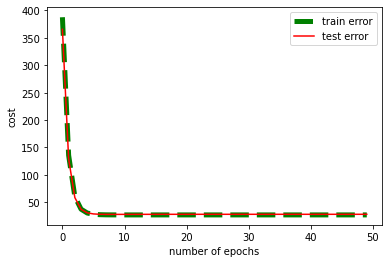

In [ ]:
plt.plot(cost_train_arr,'g--' , lw = 5 , label = 'train error' )
plt.xlabel('number of epochs')
plt.ylabel('cost')
plt.plot(cost_test_arr , 'r' , label = 'test error')
plt.legend()
plt.show()


K. Using Mini-batch GD and different split sizes in [0.1, 0.9], fit the training samples, and
predict on the training samples and test samples. Store the MSE error for each split
in an array. Use any LR of your choice. You can write a function to perform this.
Plot the train and test error as a function of the split sizes. How does the split size
affect the errors?

In [ ]:
def mini_batch_split_ratio(start_ratio,end_ratio):
  cost_arr_train = []
  cost_arr_test = []
  for ratio in np.linspace(start_ratio,end_ratio,9):
      x_train,y_train, x_test, y_test = split_data(data, split_percent = ratio)
      model = MBGD(store_cost_while_fitting=True, learning_rate=1e-4, max_iter=5000, batch_size =64)
      cost = model.fit(x_train, y_train)
      cost_arr_train.append(cost[-1])
      test_predictions = model.predict(x_test)
      cost_arr_test.append(np.sum((test_predictions.reshape(-1) - y_test.reshape(-1))**2) / len(y_test))
  return  cost_arr_train , cost_arr_test       


In [ ]:
cost_arr_train , cost_arr_test = mini_batch_split_ratio(0.1 , 0.9)

Text(0, 0.5, 'cost in train data')

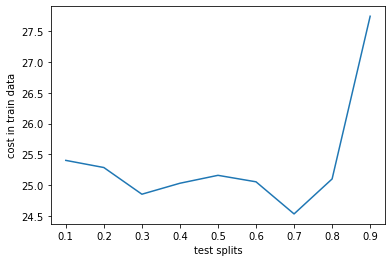

In [ ]:
plt.plot(np.linspace(0.1,0.9,9),cost_arr_train)
plt.xlabel('test splits')
plt.ylabel('cost in train data')

Text(0, 0.5, 'cost in test data')

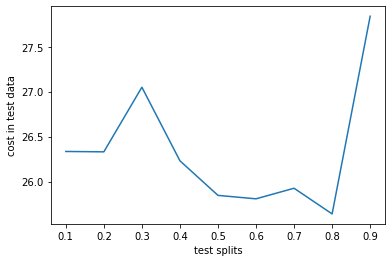

In [ ]:
plt.plot(np.linspace(0.1,0.9,9),cost_arr_test)
plt.xlabel('test splits')
plt.ylabel('cost in test data')

In [ ]:
data.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


i) Create extra new features of each existing feature by adding polynomial features
of degree 2 to your data. This can be done by squaring each of your previous
features and adding them to the Dataframe. Your total number of features should be
2N where N is the number of previous features. Call the new data, X_poly2.

In [193]:
X_poly2 = data.copy()
X_poly2['AT_SQ'] = X_poly2['AT']**2
X_poly2['V_SQ'] = X_poly2['V']**2
X_poly2['AP_SQ'] = X_poly2['AP']**2
X_poly2['RH_SQ'] = X_poly2['RH']**2

X_poly2 = X_poly2[['AT' ,'V' , 'AP' , 'RH' ,'AT_SQ','V_SQ','AP_SQ','RH_SQ', 'PE']]



X_poly2_3 = X_poly2.copy()
X_poly2_3['AT_3'] = X_poly2_3['AT']**3
X_poly2_3['V_3'] = X_poly2_3['V']**3
X_poly2_3['AP_3'] = X_poly2_3['AP']**3
X_poly2_3['RH_3'] = X_poly2_3['RH']**3

X_poly2_3 = X_poly2_3[['AT', 'V', 'AP' , 'RH' ,'AT_SQ','V_SQ','AP_SQ','RH_SQ','AT_3','V_3','AP_3','RH_3','PE']]



X_poly2_3_4 = X_poly2_3.copy()
X_poly2_3_4['AT_4'] = X_poly2_3_4['AT']**4
X_poly2_3_4['V_4'] = X_poly2_3_4['V']**4
X_poly2_3_4['AP_4'] = X_poly2_3_4['AP']**4
X_poly2_3_4['RH_4'] = X_poly2_3_4['RH']**4
X_poly2_3_4 = X_poly2_3_4[['AT' ,'V', 'AP' , 'RH' ,'AT_SQ','V_SQ','AP_SQ','RH_SQ','AT_3','V_3','AP_3','RH_3','AT_4','V_4','AP_4','RH_4','PE']]



In [194]:
X_poly2.head()

,AT,V,AP,RH,AT_SQ,V_SQ,AP_SQ,RH_SQ,PE
0,14.96,41.76,1024.07,73.17,223.8016,1743.8976,1.048719e+06,5353.8489,463.26
1,25.18,62.96,1020.04,59.08,634.0324,3963.9616,1.040482e+06,3490.4464,444.37
2,5.11,39.40,1012.16,92.14,26.1121,1552.3600,1.024468e+06,8489.7796,488.56
3,20.86,57.32,1010.24,76.64,435.1396,3285.5824,1.020585e+06,5873.6896,446.48
4,10.82,37.50,1009.23,96.62,117.0724,1406.2500,1.018545e+06,9335.4244,473.90


ii) Add new polynomial features of degree 3 of your initial features to the data. Call
the data X_poly2_3.

In [195]:
X_poly2_3.head()

,AT,V,AP,RH,AT_SQ,V_SQ,AP_SQ,RH_SQ,AT_3,V_3,AP_3,RH_3,PE
0,14.96,41.76,1024.07,73.17,223.8016,1743.8976,1.048719e+06,5353.8489,3348.071936,72825.163776,1.073962e+09,391741.124013,463.26
1,25.18,62.96,1020.04,59.08,634.0324,3963.9616,1.040482e+06,3490.4464,15964.935832,249571.022336,1.061333e+09,206215.573312,444.37
2,5.11,39.40,1012.16,92.14,26.1121,1552.3600,1.024468e+06,8489.7796,133.432831,61162.984000,1.036925e+09,782248.292344,488.56
3,20.86,57.32,1010.24,76.64,435.1396,3285.5824,1.020585e+06,5873.6896,9077.012056,188329.583168,1.031036e+09,450159.570944,446.48
4,10.82,37.50,1009.23,96.62,117.0724,1406.2500,1.018545e+06,9335.4244,1266.723368,52734.375000,1.027946e+09,901988.705528,473.90


iii) Add new polynomial features of degree 4 of your initial features to the data. Call
the data X_poly2_3_4

In [196]:
X_poly2_3_4.head()

,AT,V,AP,RH,AT_SQ,V_SQ,AP_SQ,RH_SQ,AT_3,V_3,AP_3,RH_3,AT_4,V_4,AP_4,RH_4,PE
0,14.96,41.76,1024.07,73.17,223.8016,1743.8976,1.048719e+06,5353.8489,3348.071936,72825.163776,1.073962e+09,391741.124013,50087.156163,3.041179e+06,1.099812e+12,2.866370e+07,463.26
1,25.18,62.96,1020.04,59.08,634.0324,3963.9616,1.040482e+06,3490.4464,15964.935832,249571.022336,1.061333e+09,206215.573312,401997.084250,1.571299e+07,1.082602e+12,1.218322e+07,444.37
2,5.11,39.40,1012.16,92.14,26.1121,1552.3600,1.024468e+06,8489.7796,133.432831,61162.984000,1.036925e+09,782248.292344,681.841766,2.409822e+06,1.049534e+12,7.207636e+07,488.56
3,20.86,57.32,1010.24,76.64,435.1396,3285.5824,1.020585e+06,5873.6896,9077.012056,188329.583168,1.031036e+09,450159.570944,189346.471488,1.079505e+07,1.041593e+12,3.450023e+07,446.48
4,10.82,37.50,1009.23,96.62,117.0724,1406.2500,1.018545e+06,9335.4244,1266.723368,52734.375000,1.027946e+09,901988.705528,13705.946842,1.977539e+06,1.037434e+12,8.715015e+07,473.90


In [197]:
normalize_data(X_poly2)
normalize_data(X_poly2_3)
normalize_data(X_poly2_3_4)

In [198]:
X_poly2_3_4.head()

,AT,V,AP,RH,AT_SQ,V_SQ,AP_SQ,RH_SQ,AT_3,V_3,AP_3,RH_3,AT_4,V_4,AP_4,RH_4,PE
0,0.403126,0.512016,0.991067,0.730531,0.162510,0.262160,0.982215,0.533676,0.065512,0.134230,0.973441,0.389867,0.026410,0.068728,0.964746,0.284810,463.26
1,0.678523,0.771947,0.987167,0.589856,0.460394,0.595902,0.974499,0.347930,0.312388,0.460005,0.961994,0.205229,0.211963,0.355099,0.949649,0.121056,444.37
2,0.137699,0.483080,0.979541,0.919928,0.018961,0.233366,0.959501,0.846268,0.002611,0.112735,0.939871,0.778505,0.000360,0.054460,0.920642,0.716169,488.56
3,0.562113,0.702795,0.977683,0.765176,0.315971,0.493921,0.955864,0.585494,0.177611,0.347126,0.934532,0.448006,0.099837,0.243958,0.913677,0.342803,446.48
4,0.291566,0.459784,0.976706,0.964657,0.085011,0.211402,0.953954,0.930562,0.024786,0.097199,0.931732,0.897673,0.007227,0.044691,0.910028,0.865946,473.90


iv) Using a test size of 20%, calculate the MSE for train and test data using the
different data X(initial data), X_poly2, X_poly2_3, X_poly2_3_4. Plot the train and
test MSE against the degree of polynomial of the features. Use a fixed lambda value
of zero. How does the degree affect fitting of the data?

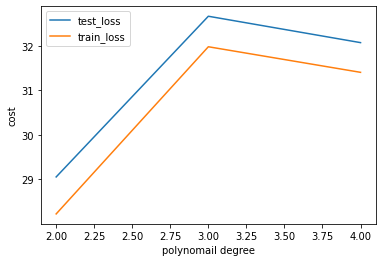

In [223]:
  polys = [X_poly2 ,X_poly2_3,X_poly2_3_4]
  cost_arr_test = []
  cost_arr_train = []
  for poly in polys:
    x_train,y_train, x_test, y_test = split_data(poly, split_percent = 0.2)
    model = MBGD(store_cost_while_fitting=True, learning_rate=1e-4, max_iter=5000, batch_size =50)
    cost = model.fit(x_train, y_train)
    test_predictions = model.predict(x_test)
    y_n = y_test
    p_n = test_predictions.reshape(len(test_predictions))
    cost_arr_test.append(np.sum((p_n - y_n)**2) / len(y_test)) 
    cost_arr_train.append(cost[-1])
  plt.plot([2,3,4], cost_arr_test , label = 'test_loss')
  plt.plot([2,3,4] ,cost_arr_train , label = 'train_loss')
  plt.xlabel('polynomail degree')
  plt.ylabel('cost')
  plt.legend()
  plt.show()



From this plot we noticed that when the degree of polynomial increases the test error increases and the training error decreases (overfiting)

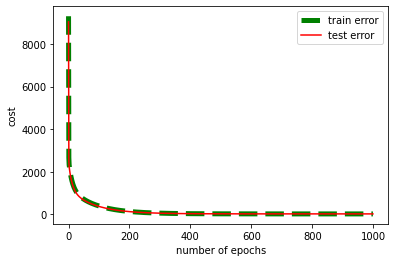

In [ ]:
plt.plot(cost_train_arr,'g--' , lw = 5 , label = 'train error' )
plt.xlabel('number of epochs')
plt.ylabel('cost')
plt.plot(cost_test_arr , 'r' , label = 'test error')
plt.legend()
plt.show()


In [ ]:
cost_train_arr_poly2 , cost_test_arr_poly2 = model.train_test_error_calculate(x_train_ploy2, y_train_poly2,x_test_poly2,y_test_poly2)

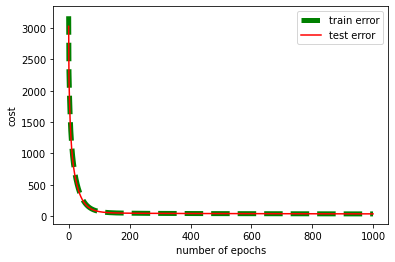

In [ ]:
plt.plot(cost_train_arr_poly2,'g--' , lw = 5 , label = 'train error' )
plt.xlabel('number of epochs')
plt.ylabel('cost')
plt.plot(cost_test_arr_poly2 , 'r' , label = 'test error')
plt.legend()
plt.show()


In [ ]:
cost_train_arr_poly3 , cost_test_arr_poly3 = model.train_test_error_calculate(x_train_ploy2_3, y_train_poly2_3,x_test_poly2_3,y_test_poly2_3)

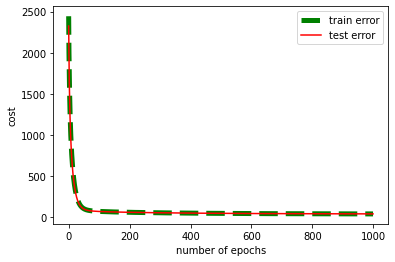

In [ ]:
plt.plot(cost_train_arr_poly3,'g--' , lw = 5 , label = 'train error' )
plt.xlabel('number of epochs')
plt.ylabel('cost')
plt.plot(cost_test_arr_poly3 , 'r' , label = 'test error')
plt.legend()
plt.show()


In [ ]:
cost_train_arr_poly4 , cost_test_arr_poly4 = model.train_test_error_calculate(x_train_ploy2_3_4, y_train_poly2_3_4,x_test_poly2_3_4,y_test_poly2_3_4)

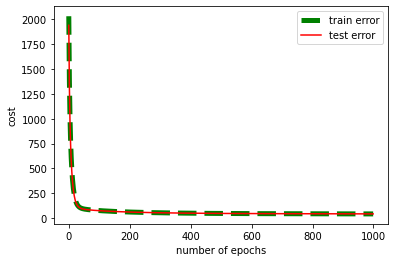

In [ ]:
plt.plot(cost_train_arr_poly4,'g--' , lw = 5 , label = 'train error' )
plt.xlabel('number of epochs')
plt.ylabel('cost')
plt.plot(cost_test_arr_poly4 , 'r' , label = 'test error')
plt.legend()
plt.show()


Select the X_poly2_3_4 dataset and regularize the model. What value of lambda
gives the best model and the corresponding MSE on the validation data?

In [ ]:
def regularize_with_different_lamdas(start , end,x_test , y_test):
  cost_arr_test = []
  arr_of_lamdas = []
  best_lamda = 0
  for lamda in np.linspace(start,end,20):
    model = MBGD_Reg(max_iter=1000, learning_rate=1e-5, store_cost_while_fitting=True, l2 = lamda)
    cost = model.fit(x_train, y_train)
    arr_of_lamdas.append(lamda)
    test_predictions = model.predict(x_test)
    y_n = y_test
    p_n = test_predictions.reshape(len(test_predictions))
    cost_arr_test.append(np.sum((p_n - y_n)**2) / len(y_test)) 
  best_lamda = arr_of_lamdas[cost_arr_test.index(min(cost_arr_test))]  
  return best_lamda , cost_arr_test

In [ ]:
best_lamda , cost_arr_test= regularize_with_different_lamdas(-10 , 10,x_test,y_test)

In [ ]:
best_lamda

0.5263157894736832

The best lambda is 0.52

Text(0, 0.5, 'MSE for test')

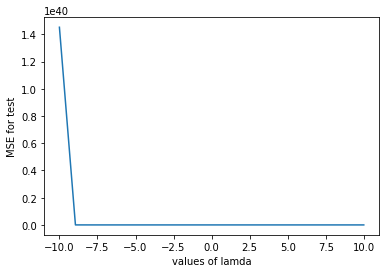

In [ ]:
plt.plot(np.linspace(-10,10,20),cost_arr_test)
plt.xlabel('values of lamda')
plt.ylabel('MSE for test')

M. Using​ Mini-batch SGD​ and learning rates in the range of [1e-9, 2], train your models
for only 3 epoch and compute the training and test losses. Plot the losses as a
function of your learning rate. How does the learning rate affect the convergence rate
and loss of the model? In which learning rate regions, is the model underfitting?

In [39]:
def mini_batch_learning_rate(start_ratio,end_ratio,step):
  cost_arr_train = []
  cost_arr_test = []
  for l_r in np.arange(start_ratio,end_ratio,step):
      model = MBGD(store_cost_while_fitting=True, learning_rate=l_r, max_iter=3, batch_size =16)
      cost = model.fit(x_train, y_train)
      cost_arr_train.append(cost[-1])
      test_predictions = model.predict(x_test)
      cost_arr_test.append(np.sum((test_predictions.reshape(-1) - y_test.reshape(-1))**2) / len(y_test))
  return  cost_arr_train , cost_arr_test       


In [ ]:
cost_arr_train , cost_arr_test = mini_batch_learning_rate(1e-9 , 2,1e-4)

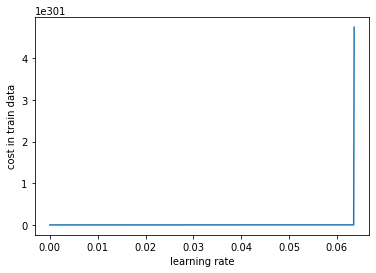

In [42]:
plt.plot(np.arange(1e-9 , 2,1e-4),cost_arr_train)
plt.xlabel('learning rate')
plt.ylabel('cost in train data')
plt.show()

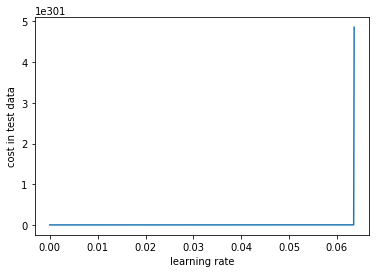

In [192]:
plt.plot(np.arange(1e-9 , 2,1e-4),cost_arr_test)
plt.xlabel('learning rate')
plt.ylabel('cost in test data')
plt.yscale('log')
plt.show()

## Cross Validation

In [ ]:
from random import randrange
def cross_validation_split(dataset, folds):
        dataset_split = []
        df_copy = dataset
        fold_size = int(df_copy.shape[0] / folds)
        
        # for loop to save each fold
        for i in range(folds):
            fold = []
            # while loop to add elements to the folds
            while len(fold) < fold_size:
                # select a random element
                r = randrange(df_copy.shape[0])
                # determine the index of this element 
                index = df_copy.index[r]
                # save the randomly selected line 
                fold.append(df_copy.loc[index].values.tolist())
                # delete the randomly selected line from
                # dataframe not to select again
                df_copy = df_copy.drop(index)
            # save the fold     
            dataset_split.append(np.asarray(fold))
            
        return dataset_split 


In [ ]:
normalize_data(data)

In [ ]:
data.head()

,AT,V,AP,RH,PE
0,0.403126,0.512016,0.991067,0.730531,463.26
1,0.678523,0.771947,0.987167,0.589856,444.37
2,0.137699,0.483080,0.979541,0.919928,488.56
3,0.562113,0.702795,0.977683,0.765176,446.48
4,0.291566,0.459784,0.976706,0.964657,473.90


In [ ]:
cross_validation_split(data,5)

[array([[5.86095392e-01, 7.98430603e-01, 9.82802671e-01, 6.58945687e-01,
         4.52890000e+02],
        [2.09646995e-01, 4.80382540e-01, 9.91599729e-01, 8.50139776e-01,
         4.84650000e+02],
        [3.93424953e-01, 5.49779304e-01, 9.90593245e-01, 8.80690895e-01,
         4.64880000e+02],
        ...,
        [6.75828618e-01, 7.48160863e-01, 9.77460563e-01, 7.30930511e-01,
         4.37310000e+02],
        [6.50498518e-01, 8.48822952e-01, 9.79773541e-01, 7.31429712e-01,
         4.33920000e+02],
        [8.49097278e-01, 8.82417852e-01, 9.75360495e-01, 7.10662939e-01,
         4.30110000e+02]]),
 array([[4.10940447e-01, 4.85286905e-01, 9.79483209e-01, 7.29333067e-01,
         4.66210000e+02],
        [2.24737268e-01, 5.02206964e-01, 9.90302913e-01, 8.93071086e-01,
         4.83920000e+02],
        [6.85260038e-01, 8.87567435e-01, 9.70337753e-01, 8.79892173e-01,
         4.36100000e+02],
        ...,
        [5.59956885e-01, 7.45953899e-01, 9.85831801e-01, 8.02715655e-01,
        

In [ ]:
def kfoldCV(dataset, f=5, k=5,l2=1,model='BGD'):
    data=cross_validation_split(dataset,f)
    cost_list = []
    best_avg_cost_for_different_lamdas=[]
    lamdas = []
    avg_cost = 0
    best_avg_cost = 0
    # determine training and test sets 
    for i in range(f):
        r = list(range(f))
        r.pop(i)
        for j in r :
            if j == r[0]:
                cv = data[j]
                
            else:    
                cv=np.concatenate((cv,data[j]), axis=0)
               
        
        # apply the selected model
        if model == 'BGD':
            model = BGD(store_cost_while_fitting=True, learning_rate=0.0001, max_iter=1000)
            x_train = cv[:,0:4]
            #print('haaaaaaaaaaaa' , type(np.array(x_train)))
            y_train = cv[:,4]
            # print('yayayayaaaaaaaaa' , np.array(y_train))
            
            x_test = data[i][:,0:4]
            print(np.array(x_test))
            y_test = data[i][:,4] 
            print('heeey' , x_test)    
            cost = model.fit(np.array(x_train), np.array(y_train))
            print("theta",model.theta)
            test_predictions = model.predict(np.array(x_test))
            print(test_predictions)
            y_n = y_test
            p_n = test_predictions.reshape(len(test_predictions))
            cost_of_fold = np.sum((p_n - y_n)**2) / len(y_test)
            cost_list.append(cost_of_fold)  
        elif model ==  'MBGD':
            model = MBGD(store_cost_while_fitting=True, learning_rate=0.0001, max_iter=1000)
            x_train = cv[:,0:4]
            #print('haaaaaaaaaaaa' , type(np.array(x_train)))
            y_train = cv[:,4]
            # print('yayayayaaaaaaaaa' , np.array(y_train))
            
            x_test = data[i][:,0:4]
            print(np.array(x_test))
            y_test = data[i][:,4] 
            print('heeey' , x_test)    
            cost = model.fit(np.array(x_train), np.array(y_train))
            print("theta",model.theta)
            test_predictions = model.predict(np.array(x_test))
            print(test_predictions)
            y_n = y_test
            p_n = test_predictions.reshape(len(test_predictions))
            cost_of_fold = np.sum((p_n - y_n)**2) / len(y_test)
            cost_list.append(cost_of_fold)
          
        elif model == 'SGD':
            model = SGD(store_cost_while_fitting=True, learning_rate=0.00001, max_iter=1000)
            x_train = cv[:,0:4]
            #print('haaaaaaaaaaaa' , type(np.array(x_train)))
            y_train = cv[:,4]
            # print('yayayayaaaaaaaaa' , np.array(y_train))
            
            x_test = data[i][:,0:4]
            print(np.array(x_test))
            y_test = data[i][:,4] 
            print('heeey' , x_test)    
            cost = model.fit(np.array(x_train), np.array(y_train))
            print("theta",model.theta)
            test_predictions = model.predict(np.array(x_test))
            print(test_predictions)
            y_n = y_test
            p_n = test_predictions.reshape(len(test_predictions))
            cost_of_fold = np.sum((p_n - y_n)**2) / len(y_test)
            cost_list.append(cost_of_fold)
        elif model == 'BGD_Reg':
            model = BGD_Reg(max_iter=10000, learning_rate=1e-4, store_cost_while_fitting=True, l2 = l2)
            x_train = cv[:,0:4]
            #print('haaaaaaaaaaaa' , type(np.array(x_train)))
            y_train = cv[:,4]
            # print('yayayayaaaaaaaaa' , np.array(y_train))
            
            x_test = data[i][:,0:4]
            print(np.array(x_test))
            y_test = data[i][:,4] 
            print('heeey' , x_test)    
            cost = model.fit(np.array(x_train), np.array(y_train))
            print("theta",model.theta)
            test_predictions = model.predict(np.array(x_test))
            print(test_predictions)
            y_n = y_test
            p_n = test_predictions.reshape(len(test_predictions))
            cost_of_fold = np.sum((p_n - y_n)**2) / len(y_test)
            cost_list.append(cost_of_fold)
            
        elif model == 'MBGD_Reg':
            model = MBGD_Reg(max_iter=10000, batch_size = 50 ,learning_rate=1e-5, store_cost_while_fitting=True, l2 = l2)
            x_train = cv[:,0:4]
            #print('haaaaaaaaaaaa' , type(np.array(x_train)))
            y_train = cv[:,4]
            # print('yayayayaaaaaaaaa' , np.array(y_train))
            
            x_test = data[i][:,0:4]
            print(np.array(x_test))
            y_test = data[i][:,4] 
            print('heeey' , x_test)    
            cost = model.fit(np.array(x_train), np.array(y_train))
            print("theta",model.theta)
            test_predictions = model.predict(np.array(x_test))
            print(test_predictions)
            y_n = y_test
            p_n = test_predictions.reshape(len(test_predictions))
            cost_of_fold = np.sum((p_n - y_n)**2) / len(y_test)
            cost_list.append(cost_of_fold)
           
    
    avg_cost = sum(cost_list) / len(cost_list) 
    # best_avg_cost_for_different_lamdas.append(avg_cost) 
    # lamdas.append(l2)
    # best_lamda = lamdas[best_avg_cost_for_different_lamdas.index(min(best_avg_cost_for_different_lamdas))]
    # best_avg_cost = min(best_avg_cost_for_different_lamdas)
    # print('best_avg_cost' ,best_avg_cost ) 
    # print('best_lamda' ,best_lamda ) 
    return avg_cost

In [ ]:
cost_list = kfoldCV(data)                     

In [ ]:
print(cost_list)

([27.455886222859995, 25.09841184556085, 25.676813245023094, 24.5685817854157, 25.198927583207155], 25.59972413641336)


In [ ]:
def regularize_with_different_lamdas_with_cross_validation(start , end, dataset , model = 'BGD'):
  cost_list = []
  lamdas = []
  for lamda in np.linspace(start,end,20):
    avg_cost = kfoldCV(dataset,l2=lamda, model = model)  
    cost_list.append(avg_cost)
    lamdas.append(lamda)
   
  return lamdas[cost_list.index(min(cost_list))] , min(cost_list)

In [ ]:
avg_cost = kfoldCV(data, model = 'BGD')

[[0.83185125 0.82540461 0.98110907 0.34484824]
 [0.32605767 0.50478176 0.981051   0.75489217]
 [0.78927513 0.86267778 0.97419917 0.60722843]
 ...
 [0.42333603 0.4919078  0.98017033 0.97304313]
 [0.69199677 0.56657675 0.97842834 0.57438099]
 [0.70439235 0.89492398 0.97502177 0.81589457]]
heeey [[0.83185125 0.82540461 0.98110907 0.34484824]
 [0.32605767 0.50478176 0.981051   0.75489217]
 [0.78927513 0.86267778 0.97419917 0.60722843]
 ...
 [0.42333603 0.4919078  0.98017033 0.97304313]
 [0.69199677 0.56657675 0.97842834 0.57438099]
 [0.70439235 0.89492398 0.97502177 0.81589457]]
theta [[-59.46949458]
 [-25.37235475]
 [518.93004638]
 [ -8.31246283]]
[[435.84820381]
 [470.62384226]
 [431.66769579]
 ...
 [462.89501017]
 [447.43325703]
 [434.58981597]]


In [ ]:
avg_cost

26.32594511071718

In [ ]:
lamda = regularize_with_different_lamdas_with_cross_validation(-10 , 10 , data ,model = 'BGD_Reg' )

[[0.3772568  0.53138794 0.9836156  0.85373403]
 [0.6558879  0.73001471 0.97165392 0.86930911]
 [0.78819725 0.88205002 0.97472177 0.63518371]
 ...
 [0.7353813  0.76826876 0.97515726 0.57927316]
 [0.79358663 0.83668465 0.97498306 0.32757588]
 [0.75990299 0.81841589 0.98553179 0.60083866]]
heeey [[0.3772568  0.53138794 0.9836156  0.85373403]
 [0.6558879  0.73001471 0.97165392 0.86930911]
 [0.78819725 0.88205002 0.97472177 0.63518371]
 ...
 [0.7353813  0.76826876 0.97515726 0.57927316]
 [0.79358663 0.83668465 0.97498306 0.32757588]
 [0.75990299 0.81841589 0.98553179 0.60083866]]
theta [[-97.0392636 ]
 [-21.98564116]
 [580.82768199]
 [-66.26667829]]
[[466.44542427]
 [427.0605493 ]
 [428.17535299]
 ...
 [439.76008343]
 [449.18567659]
 [440.87473908]]
[[0.29210455 0.49803825 0.98280267 0.60802716]
 [0.40016168 0.71836685 0.98136069 0.8970647 ]
 [0.66666667 0.78310446 0.9841382  0.55561102]
 ...
 [0.77607114 0.8776361  0.97794445 0.59774361]
 [0.39935327 0.52403139 0.99490951 0.69698482]
 [0.6

In [ ]:
lamda

-0.526315789473685

In [ ]:
min(cost_list)

24.31263103620018

In [ ]:
lamdas

[-10.0,
 -8.947368421052632,
 -7.894736842105264,
 -6.842105263157895,
 -5.7894736842105265,
 -4.736842105263158,
 -3.6842105263157894,
 -2.6315789473684212,
 -1.578947368421053,
 -0.526315789473685,
 0.5263157894736832,
 1.5789473684210513,
 2.6315789473684212,
 3.6842105263157894,
 4.7368421052631575,
 5.789473684210526,
 6.842105263157894,
 7.894736842105264,
 8.94736842105263,
 10.0]

In [ ]:
lamdas[cost_list.index(min(cost_list))]

-0.526315789473685

In [ ]:
lamda_2 , cost_2 = regularize_with_different_lamdas_with_cross_validation(-10 , 10 , data ,model = 'MBGD_Reg' )

[[0.4707626  0.77623835 0.98256073 0.88079073]
 [0.50417677 0.48295733 0.98140908 0.62719649]
 [0.63675559 0.74705738 0.97397658 0.82927316]
 ...
 [0.61007815 0.72670427 0.97994774 0.83416534]
 [0.49124225 0.55186366 0.9796187  0.73742013]
 [0.6017246  0.88205002 0.97847673 0.82717652]]
heeey [[0.4707626  0.77623835 0.98256073 0.88079073]
 [0.50417677 0.48295733 0.98140908 0.62719649]
 [0.63675559 0.74705738 0.97397658 0.82927316]
 ...
 [0.61007815 0.72670427 0.97994774 0.83416534]
 [0.49124225 0.55186366 0.9796187  0.73742013]
 [0.6017246  0.88205002 0.97847673 0.82717652]]
theta [[-1.03867020e+65]
 [ 9.77329502e+64]
 [ 4.27216993e+64]
 [-7.06792936e+64]]
[[ 6.69035287e+63]
 [-7.56883523e+63]
 [-1.01282910e+64]
 ...
 [-9.43723132e+63]
 [-7.35796394e+63]
 [ 7.04394601e+63]]
[[0.33575856 0.49938695 0.98473822 0.93320687]
 [0.83616276 0.85323688 0.97529275 0.63857827]
 [0.86418755 0.83165768 0.97542824 0.4154353 ]
 ...
 [0.7205605  0.85691515 0.98128327 0.5173722 ]
 [0.54109404 0.7735409

In [159]:
lamda_2

0.5263157894736832

In [160]:
cost_2

478.7892104585108